### Import Libraries

In [2]:
import pandas as pd
import cv2 as cv
import numpy as np
import skimage as ski
from matplotlib import pyplot as plt
from scipy import stats

### Import Image
 Change file directory

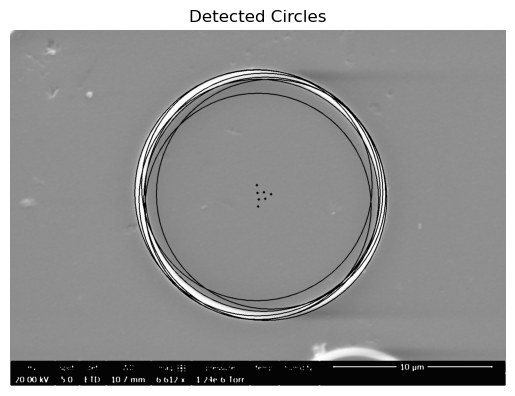

In [164]:
# Code taken from OpenCV tutorial https://docs.opencv.org/4.x/da/d53/tutorial_py_houghcircles.html
# Change file directory
Image = cv.imread('C:\\Users\\tusha\\OneDrive - Imperial College London\\20230516-ATL minicomposites part 2\\Yt_medium_006.tif',cv.IMREAD_GRAYSCALE)
# Apply smoothening mechanism to image to remove noise
Image = cv.medianBlur(Image,5)
# Detect circles with radii between 50-500 (Change depending on Image magnification)
circles = cv.HoughCircles(Image,cv.HOUGH_GRADIENT,1,20,param1=100,param2=100,minRadius=50,maxRadius=1000)
# Round the calculated values
circles2 = np.uint16(np.around(circles))


# Make a copy of Image because the code below edits the image
Image2 = Image.copy()

for i in circles2[0,:]:
    # Draw the detected circles 
    cv.circle(Image2,(i[0],i[1]),i[2],(0,255,0),2)
    # Draw the center of the detected circles
    cv.circle(Image2,(i[0],i[1]),2,(0,0,255),3)
    
# Plot the image
plt.imshow(Image2, cmap='gray')
plt.title('Detected Circles')
plt.axis('off')
plt.show()

### Corrections

You will notice that the code use both the inside and outside of the circles, soemtimes the radii calculates includes the outside of the fibres sometimes it includes just the inside, but when it takes a combination of both it shifts the centre point

[[779 506 359]
 [778 507 358]
 [772 488 334]
 [775 508 356]
 [781 506 358]
 [778 512 360]
 [780 517 358]]
[[[766 506 380]
  [770 526 371]
  [786 504 368]
  [790 524 376]
  [768 548 350]
  [764 482 357]
  [808 510 355]]]


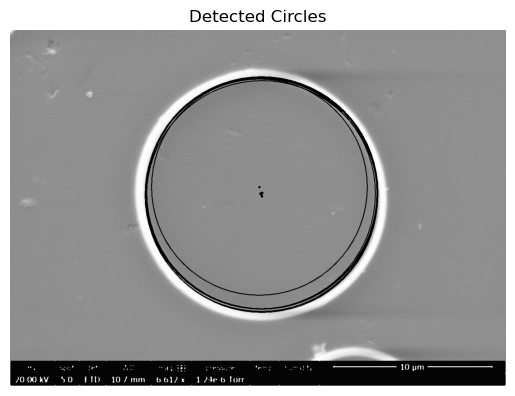

In [165]:
True_Circle = np.zeros((len(circles2[0]),3),dtype=int)
for i in range(len(circles2[0])): 
    True_Circle[i, :] = Radii_Correction(Image, circles2[0, i]).flatten()
print(True_Circle)
print(circles2)

Image3 = Image.copy()
for i in True_Circle[:]:
    # Draw the detected circles 
    cv.circle(Image3,(i[0],i[1]),i[2],(0,255,0),2)
    # Draw the center of the detected circles
    cv.circle(Image3,(i[0],i[1]),2,(0,0,255),3)
    
# Plot the image
plt.imshow(Image3, cmap='gray')
plt.title('Detected Circles')
plt.axis('off')
plt.show() 

### Rotate and Find interphase
Now we have a determined centre point, we will rotate cropped images of indervidual fibres to find the interphases.

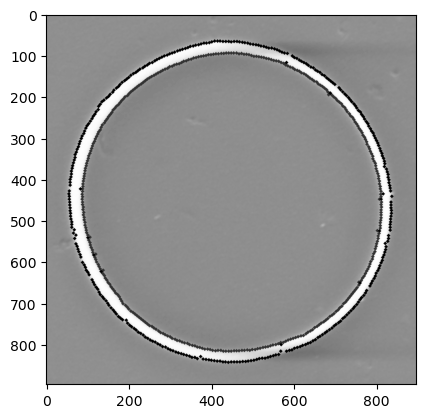

In [166]:
# Image Slicing, 
# Using the previously corrected fibre centerpoint and radius we slice out images centred 
# on the fibre centre of size 1.25x1.25 fibre radius
k = 0
cord = int(True_Circle[k,0]),int(True_Circle[k,1])
x_range = range(cord[0]-int(True_Circle[k,2]*1.25), cord[0]+int(True_Circle[k,2]*1.25))
y_range = range(cord[1]-int(True_Circle[k,2]*1.25), cord[1]+int(True_Circle[k,2]*1.25))


CroppedImage = Image[np.ix_(y_range, x_range)]
CroppedImage2 = CroppedImage.copy()

plt.imshow(CroppedImage,cmap='grey') # Remove auto brightness contrast

# Initialize Four_interphases array
Four_interphases = np.zeros((90,8), dtype=object)

# Rotate Image, copied and adjusted from OpenCV documentation
for i in range(0,90):
    rows,cols = CroppedImage.shape
    M = cv.getRotationMatrix2D(((cols-1)/2.0,(rows-1)/2.0),i,1)
    R1 = cv.warpAffine(CroppedImage,M,(cols,rows))
    Four_interphases[i] = Find_Interphase(R1,True_Circle[k])
#print(Four_interphases)
Rotated_Radii = np.concatenate((Four_interphases[:,4],Four_interphases[:,2],Four_interphases[:,6],Four_interphases[:,0]))
Rotated_Interphases = np.concatenate((Four_interphases[:,5],Four_interphases[:,3],Four_interphases[:,7],Four_interphases[:,1]))
for i in range(0,360):
    CroppedImage2[int(1.25*True_Circle[k,2]+np.cos(np.deg2rad(-i))*Rotated_Radii[i]),int(1.25*True_Circle[k,2]+np.sin(np.deg2rad(-i))*Rotated_Radii[i])] = 255
    CroppedImage2[int(1.25*True_Circle[k,2]+np.cos(np.deg2rad(-i))*(Rotated_Radii[i]+Rotated_Interphases[i])),int(1.25*True_Circle[k,2]+np.sin(np.deg2rad(-i))*(Rotated_Radii[i]+Rotated_Interphases[i]))] = 0

for i in range(0,360):
    cv.circle(CroppedImage2,(int(1.25*True_Circle[k,2]+np.sin(np.deg2rad(-i))*Rotated_Radii[i]),int(1.25*True_Circle[k,2]+np.cos(np.deg2rad(-i))*Rotated_Radii[i])),2,(50,50,50),3)
    cv.circle(CroppedImage2,(int(1.25*True_Circle[k,2]+np.sin(np.deg2rad(-i))*(Rotated_Radii[i]+Rotated_Interphases[i])),int(1.25*True_Circle[k,2]+np.cos(np.deg2rad(-i))*(Rotated_Radii[i]+Rotated_Interphases[i]))),2,(0,0,0),3)

plt.imshow(CroppedImage2,cmap='grey') # Remove auto brightness contrast

In [5]:
def rotate_and_find_interphase(Im,circle):
    Four_interphases = np.zeros((90,8), dtype=object)

# Rotate Image, copied and adjusted from OpenCV documentation
    for i in range(0,90):
        rows,cols = CroppedImage.shape
        M = cv.getRotationMatrix2D(((cols-1)/2.0,(rows-1)/2.0),i,1)
        R1 = cv.warpAffine(CroppedImage,M,(cols,rows))
        Four_interphases[i] = Find_Interphase(R1,circle)
    #print(Four_interphases)
    Rotated_Radii = np.concatenate((Four_interphases[:,4],Four_interphases[:,2],Four_interphases[:,6],Four_interphases[:,0]))
    Rotated_Interphases = np.concatenate((Four_interphases[:,5],Four_interphases[:,3],Four_interphases[:,7],Four_interphases[:,1]))
    for i in range(0,360):
        CroppedImage2[int(1.25*circle[2]+np.cos(np.deg2rad(-i))*Rotated_Radii[i]),int(1.25*circle[2]+np.sin(np.deg2rad(-i))*Rotated_Radii[i])] = 255
        CroppedImage2[int(1.25*circle[2]+np.cos(np.deg2rad(-i))*(Rotated_Radii[i]+Rotated_Interphases[i])),int(1.25*circle[2]+np.sin(np.deg2rad(-i))*(Rotated_Radii[i]+Rotated_Interphases[i]))] = 0

    return Rotated_Radii, Rotated_Interphases, CroppedImage2
        

In [6]:
def find_fibre_from_outliers(outliers,intit_radii):
    outliers = np.sort(outliers)

    # Add thickness condition
    min_radiit = False
    radii_sizet = False
    for i in range(0,len(outliers)):
        
        if min_radiit == False:
            min_radii = outliers[i]
            if min_radii >= 0.75*intit_radii:
                min_radiit = True
                
            # Find the size of the change in grey level caused by the end of the fibre.        
        if radii_sizet == False and min_radiit == True:
            
            if int(outliers[i+1]) - int(outliers[i]) != 1:
                radii_sizet = True
                max_radii = outliers[i]
    radii = int(np.mean([min_radii, max_radii]))
    
    return radii

In [24]:
def find_interphase_from_outliers(outliers,intit_radii):
    outliers = np.sort(outliers)

    # Add thickness condition
    min_radiit = False
    radii_sizet = False
    interphase_sizet = False
    for i in range(0,len(outliers)):
        
        if min_radiit == False and outliers[i] >= 0.75*intit_radii:
            min_radiit = True
            min_radii = outliers[i]
                
            # Find the size of the change in grey level caused by the end of the fibre.        
        if radii_sizet == False and min_radiit == True:
            if int(outliers[i+1]) - int(outliers[i]) != 1:
                radii_sizet = True
                max_radii = outliers[i]
                min_outerinterphase = outliers[i+1]
        if radii_sizet == True and interphase_sizet == False:
            if i == len(outliers)-1:
                interphase_sizet = True
                outer_interphase = outliers[i]
            else:    
                if int(outliers[i+1]) - int(outliers[i]) != 1 and outliers[i] != max_radii:
                    interphase_sizet = True
                    outer_interphase = outliers[i]

    radii = int(np.mean([min_radii, max_radii]))
    interphase_size = int(np.mean([outer_interphase, min_outerinterphase])) - radii
    
    return radii, interphase_size

In [95]:
def Radii_Correction(Im,circle):
    xline = np.array(range(circle[0]-int(circle[2]*1.25),circle[0]+int(circle[2]*1.25))) # Set range of values to correct over
    yline = np.array(range(circle[1]-int(circle[2]*1.25),circle[1]+int(circle[2]*1.25))) # Set range of values to correct over
    greyx = np.zeros(len(xline), dtype=int)  # Initialize greyx as a numpy array
    greyy = np.zeros(len(xline), dtype=int)  # Initialize greyx as a numpy array

    cordx = np.zeros((len(xline), 2), dtype=int)
    cordy = np.zeros((len(yline), 2), dtype=int)

    for i in range(len(xline)):
        cordx[i,0] = xline[i]
        cordx[i,1] = circle[1]
        greyx[i] = Im[cordx[i,1],cordx[i,0]]
    

    for i in range(len(yline)):
        cordy[i,1] = yline[i]
        cordy[i,0] = circle[0]
        greyy[i] = Im[cordy[i,1],cordy[i,0]] 

    xgrey_grad = np.gradient(greyx)
    ygrey_grad = np.gradient(greyy)

    z_scoresx = stats.zscore(xgrey_grad)
    z_scoresy = stats.zscore(ygrey_grad)

    threshold = 1

    # Find the indices of the outliers
    xoutliers = np.where(np.abs(z_scoresx) > threshold)
    youtliers = np.where(np.abs(z_scoresy) > threshold)

    #Find centre point of outliers
    cord = int(circle[0]),int(circle[1])
    corddx = cord - cordx[xoutliers[0]]
    corddy = cord - cordy[youtliers[0]]
    corddx_positive = corddx[corddx[:, 0] >= 0]
    corddx_negative = corddx[corddx[:, 0] < 0]
    corddy_positive = corddy[corddy[:, 1] >= 0]
    corddy_negative = corddy[corddy[:, 1] < 0]


    negative_distance_outlierx = np.power(np.power(corddx_negative[0:,0],2)+np.power(corddx_negative[0:,1],2),0.5)
    postive_distance_outlierx = np.power(np.power(corddx_positive[0:,0],2)+np.power(corddx_positive[0:,1],2),0.5)
    radii1x = find_fibre_from_outliers(negative_distance_outlierx,circle[2])
    radii2x = find_fibre_from_outliers(postive_distance_outlierx,circle[2])

    negative_distance_outliery = np.power(np.power(corddy_negative[0:,0],2)+np.power(corddy_negative[0:,1],2),0.5)
    postive_distance_outliery = np.power(np.power(corddy_positive[0:,0],2)+np.power(corddy_positive[0:,1],2),0.5)
    radii1y = find_fibre_from_outliers(negative_distance_outliery,circle[2])
    radii2y = find_fibre_from_outliers(postive_distance_outliery,circle[2])
    xchange = False
    ychange = False
    new_circle = np.zeros((3,1),dtype=int)
    if abs(radii1x - radii2x) >= 2:
        radii_dx = radii2x - radii1x
        new_circle[0] = circle[0] - radii_dx/2
        xchange = True
    else: 
        radii_dx = 0
        new_circle[0] = circle[0]
    if abs(radii1y - radii2y) >= 2:
        radii_dy = radii2y - radii1y
        new_circle[1] = circle[1] - radii_dy/2
        ychange = True
    else: 
        radii_dy = 0
        new_circle[1] = circle[1]

    new_circle[2] = int(np.mean([radii1x,radii1y,radii2x,radii2y]))

    return new_circle

In [104]:
def Find_Interphase(Im,circle):
    xline = np.array(range(0,len(Im[0,:]))) # Set range of values to correct over
    yline = np.array(range(0,len(Im[0,:]))) # Set range of values to correct over
    greyx = np.zeros(len(xline), dtype=int)  # Initialize greyx as a numpy array
    greyy = np.zeros(len(xline), dtype=int)  # Initialize greyx as a numpy array

    cordx = np.zeros((len(xline), 2), dtype=int)
    cordy = np.zeros((len(yline), 2), dtype=int)

    for i in range(len(xline)):
        cordx[i,0] = xline[i]
        cordx[i,1] = 1.25*circle[2]
        greyx[i] = Im[cordx[i,1],cordx[i,0]]


    for i in range(len(yline)):
        cordy[i,1] = yline[i]
        cordy[i,0] = 1.25*circle[2]
        greyy[i] = Im[cordy[i,1],cordy[i,0]] 

    xgrey_grad = np.gradient(greyx)
    ygrey_grad = np.gradient(greyy)

    z_scoresx = stats.zscore(xgrey_grad)
    z_scoresy = stats.zscore(ygrey_grad)

    threshold = 3

    
    # Find the indices of the outliers
    xoutliers = np.where(np.abs(z_scoresx) > threshold)
    youtliers = np.where(np.abs(z_scoresy) > threshold)

    #Find centre point of outliers
    cord = int(1.25*circle[2]),int(1.25*circle[2])
    corddx = cord - cordx[xoutliers[0]]
    corddy = cord - cordy[youtliers[0]]
    corddx_positive = corddx[corddx[:, 0] >= 0]
    corddx_negative = corddx[corddx[:, 0] < 0]
    corddy_positive = corddy[corddy[:, 1] >= 0]
    corddy_negative = corddy[corddy[:, 1] < 0]

    negative_distance_outlierx = np.power(np.power(corddx_negative[0:,0],2)+np.power(corddx_negative[0:,1],2),0.5)
    postive_distance_outlierx = np.power(np.power(corddx_positive[0:,0],2)+np.power(corddx_positive[0:,1],2),0.5)
    radii1x,interphase1x = find_interphase_from_outliers(negative_distance_outlierx,circle[2])
    radii2x,interphase2x = find_interphase_from_outliers(postive_distance_outlierx,circle[2])

    negative_distance_outliery = np.power(np.power(corddy_negative[0:,0],2)+np.power(corddy_negative[0:,1],2),0.5)
    postive_distance_outliery = np.power(np.power(corddy_positive[0:,0],2)+np.power(corddy_positive[0:,1],2),0.5)
    radii1y, interphase1y = find_interphase_from_outliers(negative_distance_outliery,circle[2])
    radii2y, interphase2y = find_interphase_from_outliers(postive_distance_outliery,circle[2])
    return radii1x,interphase1x, radii2x,interphase2x, radii1y, interphase1y, radii2y, interphase2y

Text(0.5, 0, 'Coating thickness(pixels)')

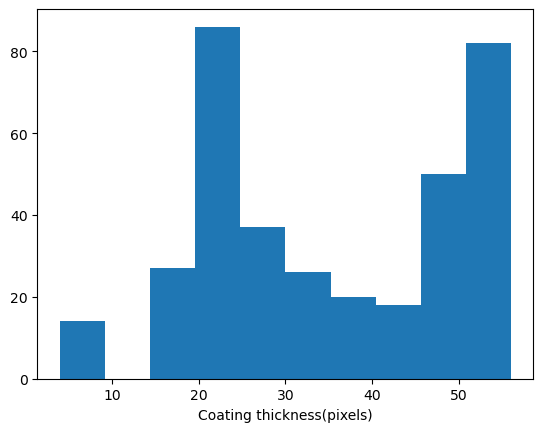

In [135]:
plt.hist(Rotated_Interphases)
plt.xlabel('Coating thickness(pixels)')